# Assignment 4

## AWS Function

In [1]:
def run_on_aws(input_file, output_dir, spark_session):
    """Start of the PySpark code to run on AWS
    """

    import os
    import math
    import pyspark.sql.functions as F

    from pyspark.sql.types import StructType
    from pyspark.sql.types import StringType
    from pyspark.sql.types import DateType
    from pyspark.sql.types import IntegerType
    from pyspark.sql.types import FloatType
    from pyspark.sql.types import LongType
    from pyspark.sql.window import Window
    from pyspark.ml.feature import Bucketizer

    schema = StructType() \
            .add('CMTE_ID', StringType()) \
            .add('AMNDT_IND', StringType()) \
            .add('RPT_TP', StringType()) \
            .add('TRANSACTION_PGI', StringType()) \
            .add('IMAGE_NUM', StringType()) \
            .add('TRANSACTION_TP', StringType()) \
            .add('ENTITY_TP', StringType()) \
            .add('NAME', StringType()) \
            .add('CITY', StringType()) \
            .add('STATE', StringType()) \
            .add('ZIP_CODE', StringType()) \
            .add('EMPLOYER', StringType()) \
            .add('OCCUPATION', StringType()) \
            .add('TRANSACTION_DT', StringType()) \
            .add('TRANSACTION_AMT', FloatType()) \
            .add('OTHER_ID', StringType()) \
            .add('TRAN_ID', StringType()) \
            .add('FILE_NUM', IntegerType()) \
            .add('MEMO_CD', StringType()) \
            .add('MEMO_TEXT', StringType()) \
            .add('SUB_ID', LongType()) \
    
    campaign_ids = {'C00575795': 'HILLARY FOR AMERICA',
                    'C00577130': 'BERNIE 2016',
                    'C00580100': 'DONALD J. TRUMP FOR PRESIDENT, INC'}

    df = spark_session.read.csv(input_file, schema=schema, sep='|')
    
    # Convert date string to Date Type
    df = df.withColumn("TRANSACTION_DT", F.to_date(df["TRANSACTION_DT"],"mmddyyyy"))
    df = df.select("*") \
            .where(df['CMTE_ID'].isin(list(campaign_ids.keys()))) \
    

    # Problem 1: Number of donations for each campaign
    # Filter out all negative valued transactions, as we just want to count how many donations are there
    df.select(['CMTE_ID', 'TRANSACTION_AMT']) \
        .where(df['TRANSACTION_AMT'] > 0) \
        .groupby(df['CMTE_ID']) \
        .count() \
        .coalesce(1) \
        .write.format('csv').save(os.path.join(output_dir, 'problem_1'))

    # Problem 2: Total amount of donations for each campaign
    # Negative transaction amounts (aka refunds) will cancel out so no need to filter out anything
    df.select(['CMTE_ID', 'TRANSACTION_AMT']) \
        .groupby(df['CMTE_ID']) \
        .sum() \
        .coalesce(1) \
        .write.format('csv').save(os.path.join(output_dir, 'problem_2'))

    # Problem 3: Percentage of small contributors for each campaign
    small_contributor_limit = 200
    df.select(['CMTE_ID', 'TRANSACTION_AMT', 'NAME']) \
        .groupby(df['CMTE_ID'], df['NAME']) \
        .sum() \
        .where(F.col('sum(TRANSACTION_AMT)') > 0) \
        .withColumn('small',
                    F.when(F.col('sum(TRANSACTION_AMT)') < small_contributor_limit, 1).otherwise(0)
                   ) \
        .withColumn('total',
                    F.lit(1)
                   ) \
        .groupby(df['CMTE_ID']) \
        .sum() \
        .withColumn('percent',
                    F.col('sum(small)')*100/F.col('sum(total)')
                   ) \
        .coalesce(1) \
        .write.format('csv').save(os.path.join(output_dir, 'problem_3'))

    # Problem 4: Histogram data for each campaign
    # Find out the max valued donation and create a log scale up to that
    max_val = int(df.select(F.max(df['TRANSACTION_AMT']).alias('MAX')).collect()[0].MAX)
    max_exp = int(math.ceil(math.log10(max_val)))
    split_list = [10**i for i in range(0, max_exp+1)]
    
    base_df = df.select(['CMTE_ID', 'TRANSACTION_AMT']) \
        .where(df['CMTE_ID'].isin(list(campaign_ids.keys()))) \
        .where(df['TRANSACTION_AMT'] > 0)
    
    schema = StructType() \
                .add("CMTE_ID", StringType()) \
                .add("TRANSACTION_AMT", FloatType()) \
                .add("buckets", FloatType())
    df_bucketed = spark_session.createDataFrame([], schema)

    for campaign_id in campaign_ids.keys():
        bucketizer = Bucketizer(splits=split_list, inputCol="TRANSACTION_AMT", outputCol="buckets")
        df_to_append = bucketizer.transform(base_df.where(base_df['CMTE_ID'] == campaign_id))
        df_bucketed = df_bucketed.union(df_to_append)
    
    df_bucketed.groupby(['CMTE_ID', 'buckets']) \
                .count() \
                .sort(['CMTE_ID', 'buckets']) \
                .coalesce(1) \
                .write.format('csv').save(os.path.join(output_dir, 'problem_4'))

### AWS Command:

`aws emr create-cluster --applications Name=Ganglia Name=Spark Name=Zeppelin --ebs-root-volume-size 10 --ec2-attributes '{"KeyName":"manav-key-pair","InstanceProfile":"EMR_EC2_DefaultRole","SubnetId":"subnet-702a6b5e","EmrManagedSlaveSecurityGroup":"sg-09755235c7aa8a6d5","EmrManagedMasterSecurityGroup":"sg-0aff94f7bce22c1db"}' --service-role EMR_DefaultRole --enable-debugging --release-label emr-5.23.0 --log-uri 's3n://aws-logs-546987341530-us-east-1/elasticmapreduce/' --steps '[{"Args":["spark-submit","--deploy-mode","client","s3://manavs-bucket/aws.py","-i","s3://rw-cs696-data/itcont.txt","-o","s3://manavs-bucket/results"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Spark application"}]' --name 'Manav'\''s Spark Cluster' --instance-groups '[{"InstanceCount":1,"InstanceGroupType":"MASTER","InstanceType":"m3.xlarge","Name":"Master Instance Group"},{"InstanceCount":3,"InstanceGroupType":"CORE","InstanceType":"m3.xlarge","Name":"Core Instance Group"}]' --scale-down-behavior TERMINATE_AT_TASK_COMPLETION --region us-east-1`

**Note:** You can uncomment the following line and provide the sample text file as input to run the AWS function locally. Then the resulting files can be provided to the respective cells for visualization & testing.

In [2]:
# run_on_aws('./data.txt', './results', spark)

## Plotting the results

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def plot_large():
    plt.figure(dpi=200, figsize=(8, 5))

campaign_ids = {'C00575795': 'HILLARY FOR AMERICA',
                'C00577130': 'BERNIE 2016',
                'C00580100': 'DONALD J. TRUMP FOR PRESIDENT, INC'}

sns.set(palette='Set2')

### Problem 1: Number of donations per campaign

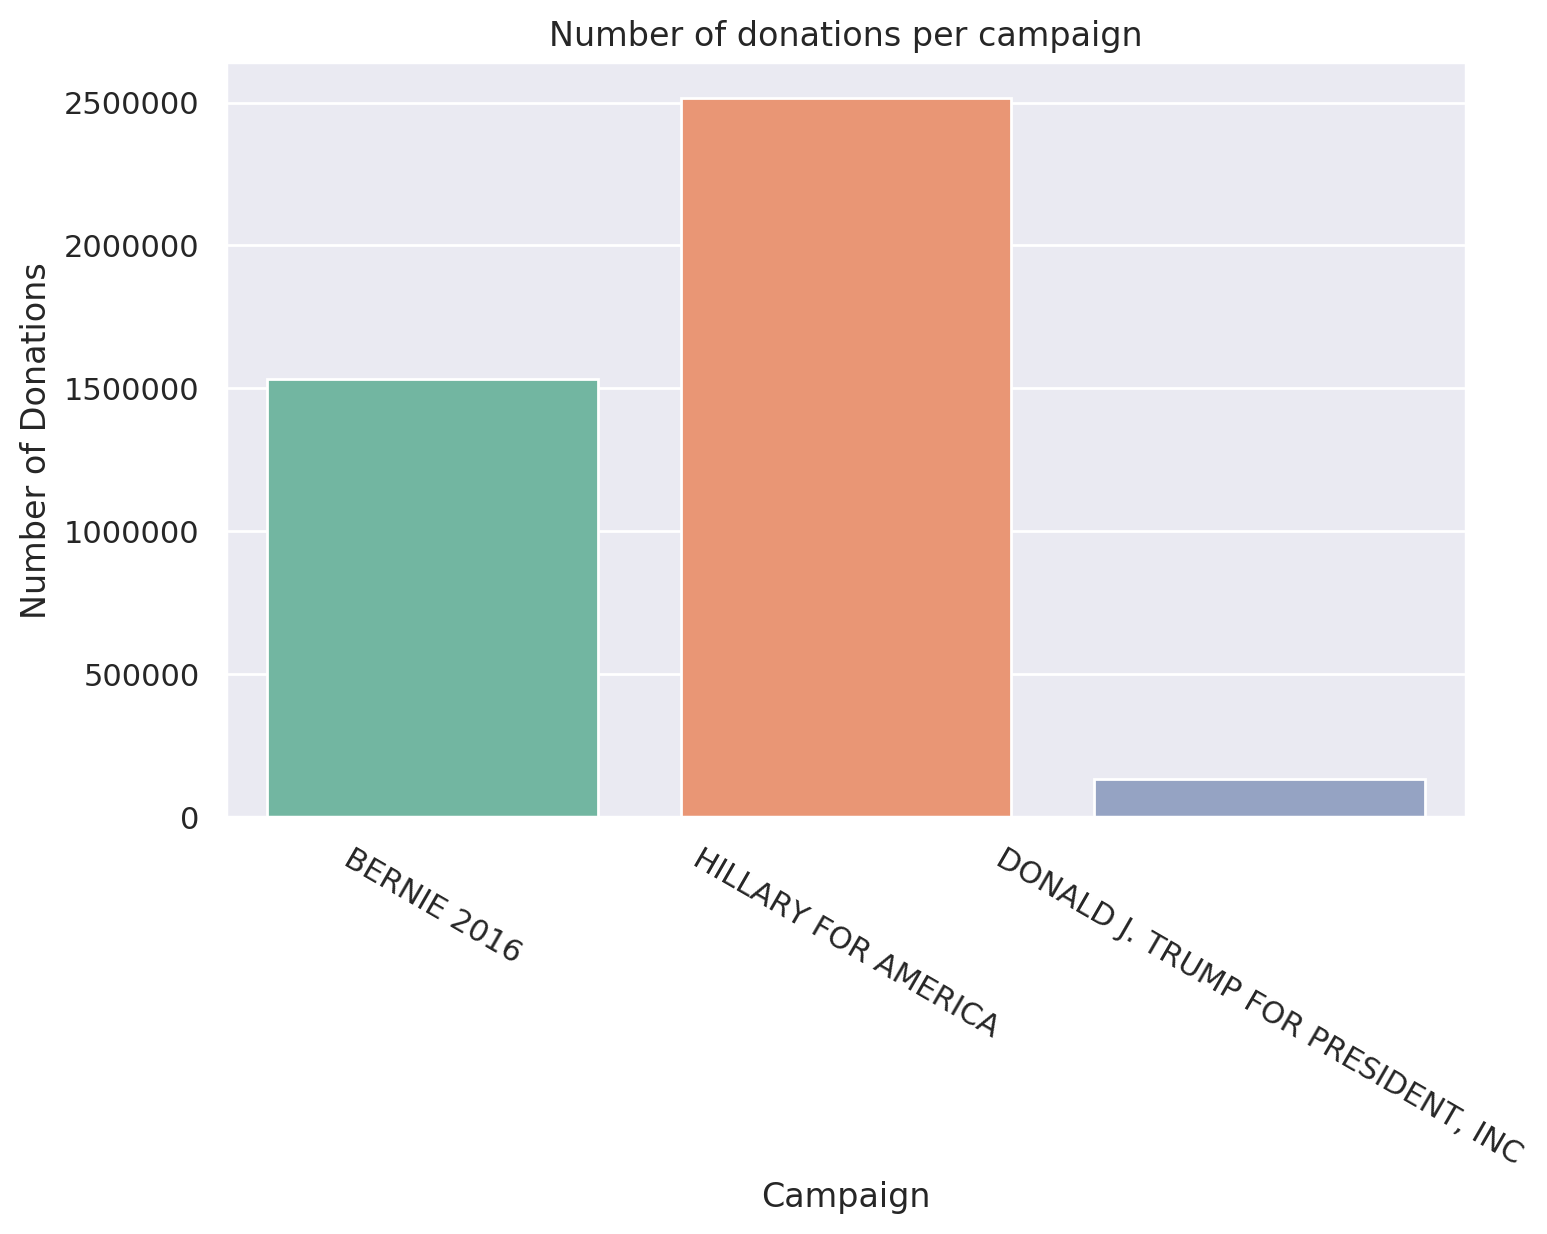

In [5]:
problem1_df = pd.read_csv('./1.csv', names=['Campaign', 'Number of Donations'])
problem1_df['Campaign'] = [campaign_ids[id_number] for id_number in problem1_df['Campaign']]

plot_large()
sns.barplot(x='Campaign', y='Number of Donations', data=problem1_df)
plt.xticks(rotation=-30)
plt.title('Number of donations per campaign');

### Problem 2: Total donation amount per campaign

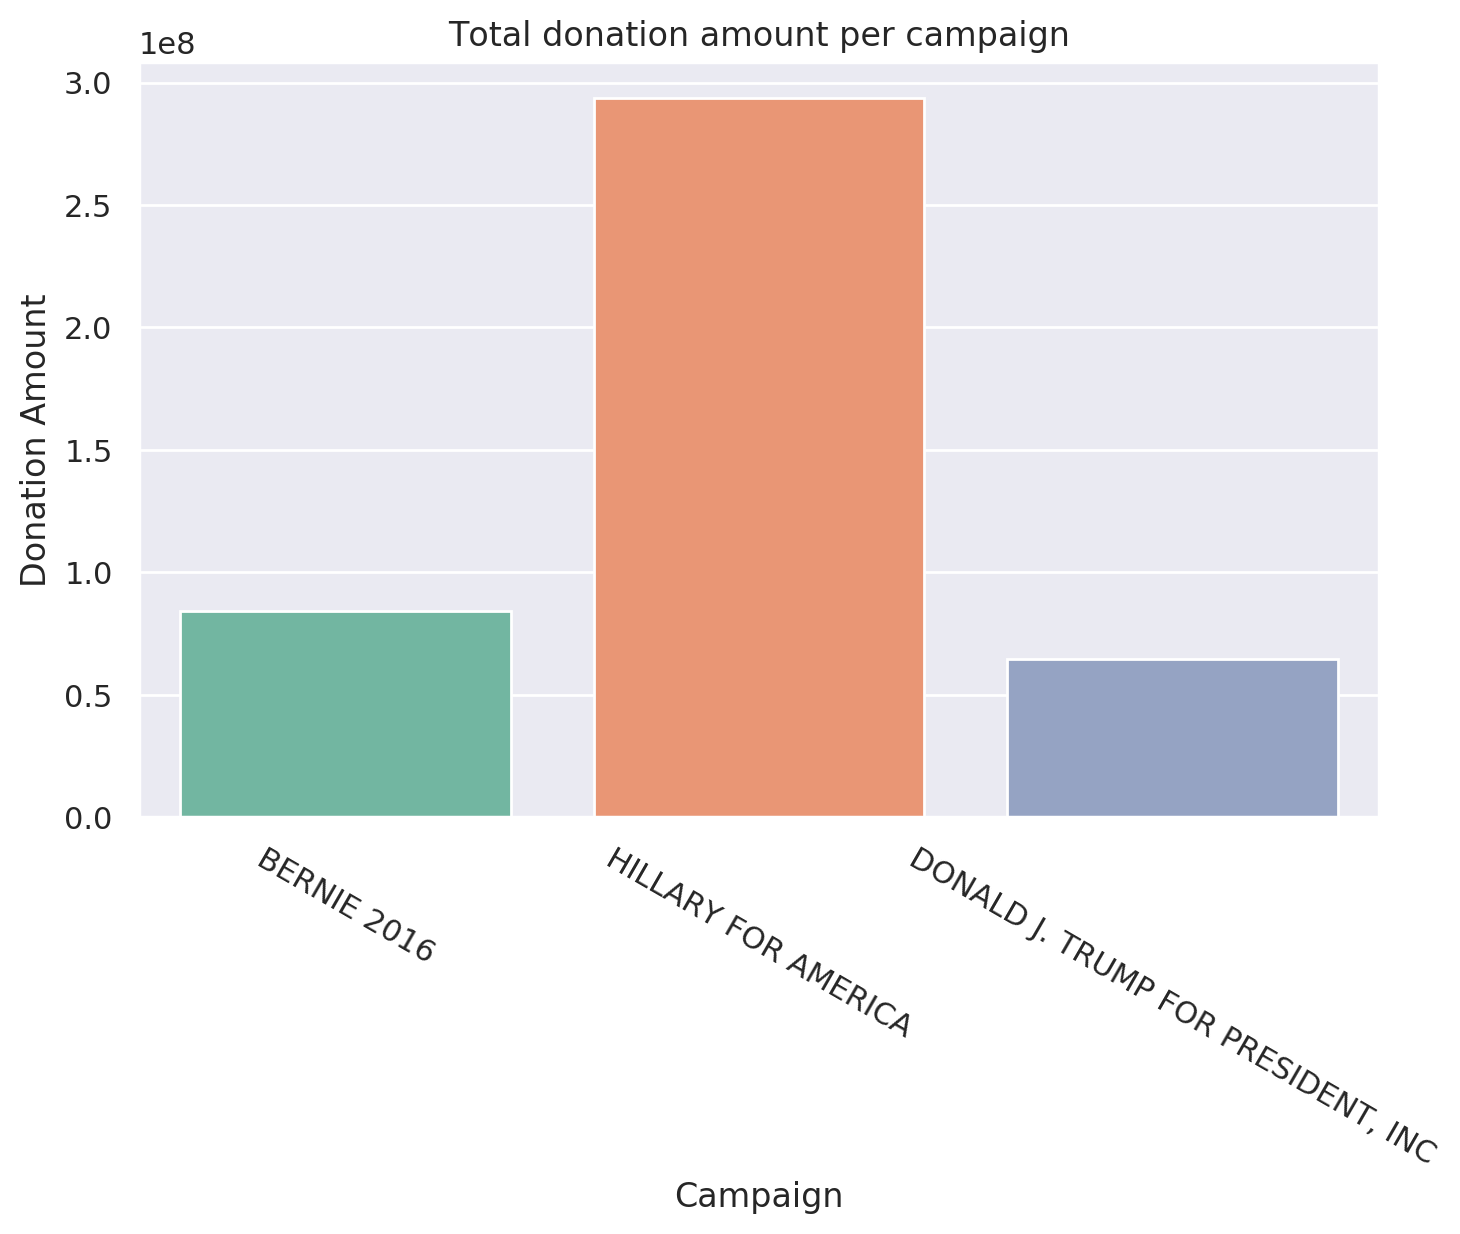

In [6]:
problem2_df = pd.read_csv('./2.csv', names=['Campaign', 'Donation Amount'])
problem2_df['Campaign'] = [campaign_ids[id_number] for id_number in problem2_df['Campaign']]

plot_large()
sns.barplot(x='Campaign', y='Donation Amount', data=problem2_df)
plt.xticks(rotation=-30)
plt.title('Total donation amount per campaign');

### Problem 3: Percentage of small contributors per campaign

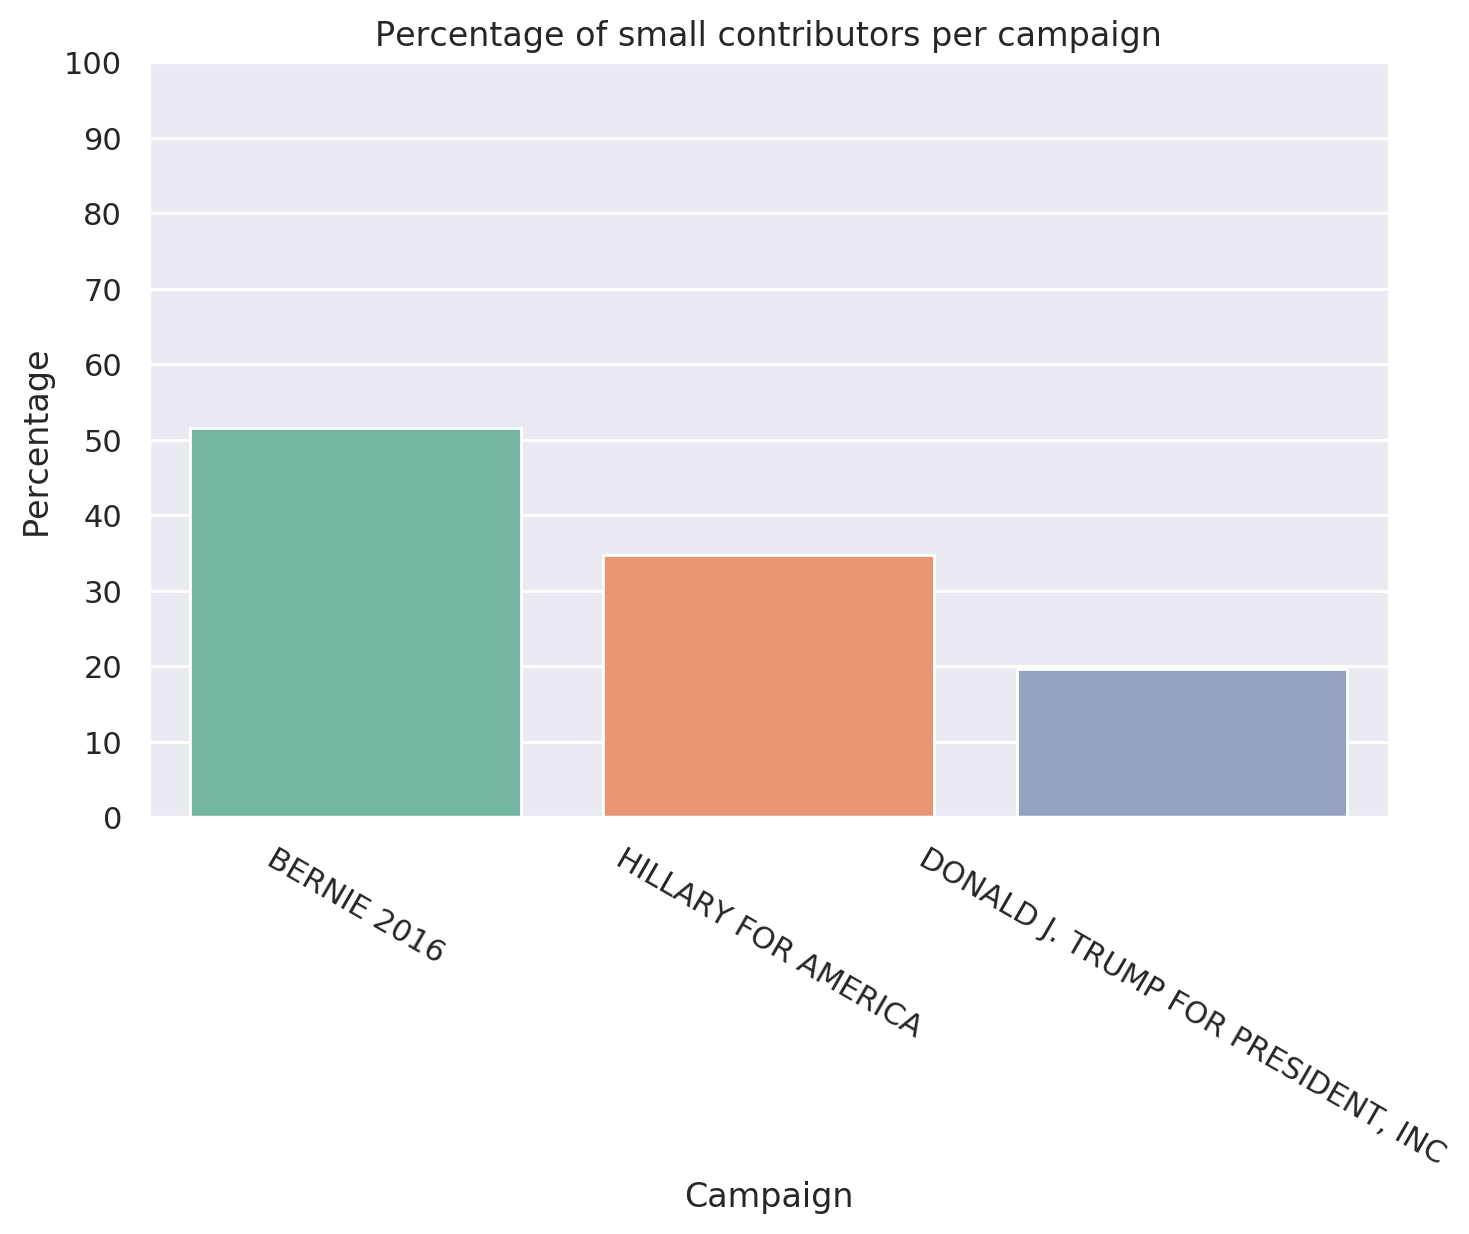

In [7]:
problem3_df = pd.read_csv('./3.csv', names=['Campaign', '_', 'Small Contributors', 'Total Contributors', 'Percentage'])
problem3_df['Campaign'] = [campaign_ids[id_number] for id_number in problem3_df['Campaign']]

plot_large()
sns.barplot(x='Campaign', y='Percentage', data=problem3_df)
plt.xticks(rotation=-30)
plt.yticks(range(0, 101, 10))
plt.title('Percentage of small contributors per campaign');

### Problem 4: Histogram of donations

The axes in the below graphs are log scale. For example, on the x axis the first tick is 1, so the first set shows the number of donations which have a value between 1 (inclusive) and 10 (exclusive).

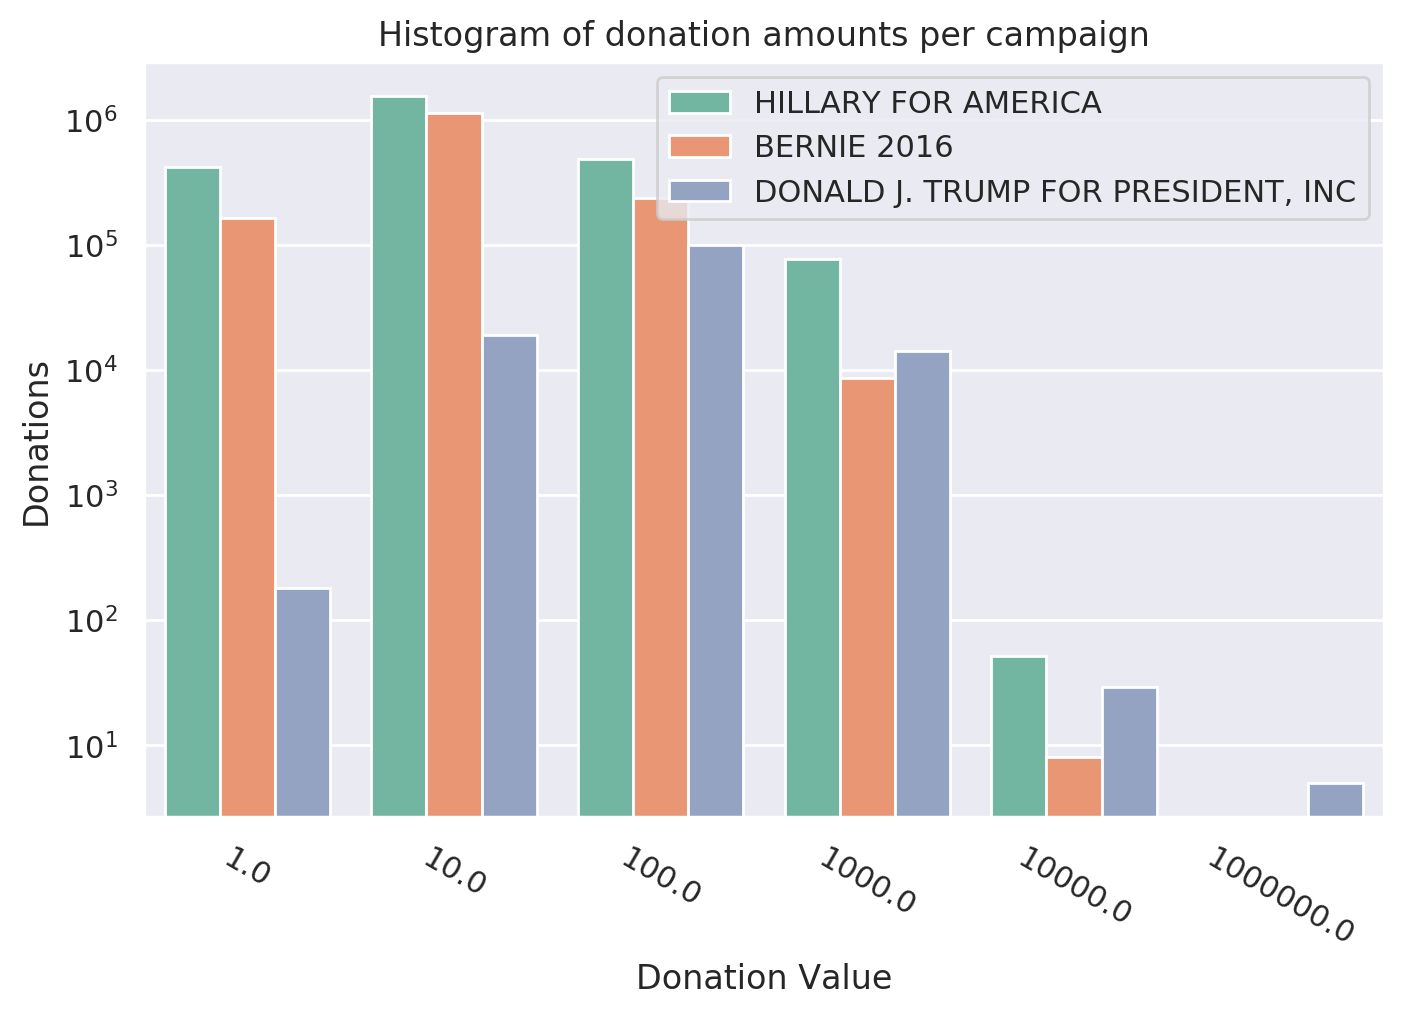

In [10]:
problem4_df = pd.read_csv('./4.csv', names=['Campaign', 'Donation Value', 'Donations'])
problem4_df['Donation Value'] = [10**i for i in problem4_df['Donation Value']]
problem4_df['Campaign'] = [campaign_ids[id_number] for id_number in problem4_df['Campaign']]

plot_large()
sns.barplot(x='Donation Value', y='Donations', hue='Campaign', data=problem4_df)
plt.yscale("log")
plt.xticks(rotation=-30)
plt.title('Histogram of donation amounts per campaign')
plt.legend(loc='upper right');